# Data Extractions from OpenEO

To run the extractions, you need an account in the [Copernicus Data Space Ecosystem (CDSE)](https://dataspace.copernicus.eu/).

In [ ]:
!pip install git+https://github.com/WorldCereal/prometheo.git --quiet
!pip install git+https://github.com/ScaleAGData/scaleag-vito.git --quiet

In [1]:
from pathlib import Path
import geopandas as gpd
from loguru import logger
from scaleagdata_vito.presto.datasets_prometheo import ScaleAgDataset
from scaleagdata_vito.openeo.extract_sample_scaleag import generate_input_for_extractions, extract
from scaleagdata_vito.presto.presto_df import load_dataset
from scaleagdata_vito.presto.utils import train_test_val_split, finetune_on_task, load_finetuned_model, evaluate_finetuned_model, get_pretrained_model_url
from scaleagdata_vito.presto.inference import PrestoPredictor, reshape_result, plot_results
from scaleagdata_vito.utils.map import ui_map
from scaleagdata_vito.utils.dateslider import date_slider
from scaleagdata_vito.openeo.extract_sample_scaleag import collect_inputs_for_inference

### Before we start...

**Check your data!** Investigate validity of geometries uniqueness of sample IDs, presence of outliers and so on before starting the extraction. Achieving good performance making use of a limited amount of data is a challening task per se. Therefore, **the quality of your data will greatly impact your final results.**

Data requirements:
- Points or Polygons (will be aggregated in points)
- Lat-Lon (crs:4326) 
- Format: parquet, GeoJSON, shapefile, GPKG
For each geometry:
- Date (if available) 
- Unique ID
- Annotations

Good practice:

Remove polygons close to borders (e.g. apply buffer) to ensure data are contained in the field
If the annotations are accurate, point geometries should be preferred. However, especially in regression tasks (i.e., continuous output values) such us yield estimation the target values might be noisy. In that case, we recommend subdividing the polygons in subfields of 20m x 20m (to cover more measurements) and computing the median yield for a smoother and more reliable target

##### Assess data correctness before launching the OpenEO jobs 
You can run some checks on your input file to make sure they are suitable to run the extractions successfully. In particular, it is important to check the validity of the geometries and, to also have a column containing a unique id for each sample. Do these checks beforehand by running the first section of the notebook `data_investigation.ipynb`

##### Requirements for running the extractions
- Account in [Copernicus Data Space Ecosystem (CDSE)](https://dataspace.copernicus.eu/). You can sign up for free and have a monthly availability of 10000 credits.
- A dataset with valid geometries (Points or Polygons) in lat-lon projection.
- Preferably a dataset with unique IDs per sample 
- A labelled dataset. Not required for the extraction process, but for the following fine-tuning steps.

##### EO data extractions
In this first step, we extract for each sample in your dataset the required EO time series from CDSE using OpenEO.
For running the job, the user should indicate the following job_dictionary fields:

```python
    job_params = dict(
        output_folder=..., # where to save the extracted dataset
        input_df=..., # input georeferenced dataset to run the extractions for 
        start_date=..., # string indicating from which date to extract data  
        end_date=..., # string indicating until which date to extract the data 
        unique_id_column=..., # name of the column in the input_df containing the unique ID of the samples  
        composite_window=..., # "month" or "dekad" are supported. Default is "dekad"
    )
```
in particular:
- If the `date` information associated with the label is provided, the `start_date` of the time-series is automatically set to 9 months before the date, whereas the `end_date` is set to 9 months after. If `date` is not available, the user needs to manually indicate the desired `start_date` and `end_date` for the extractions. **The indicated period should cover 1 year**. 
- `composite_window` indicates the time-series granularity, which can be dekadal or monthly. 
  - `dekad`: each time step in the extracted time series corresponds to a mean-compositing operation on 10-days acquisitions. Accordingly with the start and end date, each month will be covered by 3 time steps which, by default, correspond to the 1st, 11th and 21th of the month. 
  - `month`: each time step in the extracted time series corresponds to a mean-compositing operation on 30-days acquisitions. Each month will be covered by 1 time step which, by default, correspond to the 1st of the month.

The following decadal/monthly time series will be extracted for the indicated time range:

- Sentinel-2 L2A data (all bands)
- Sentinel-1 VH and VV
- Average air temperature and precipitation sum derived from AgERA5
- Slope and elevation from Copernicus DEM

Presto accepts 1D time-series. Therefore, if Polygons are provided for the extractions, the latter are spatially aggregated in points which will correspond to the centroid lat lon geolocation.

### 1) Run extractions

In [2]:
# Dataset Parameters
start_date="2023-01-01"
end_date="2023-12-31"
composite_window="dekad"
unique_id_column="Field_ID"
input_df="/home/giorgia/Private/data/geomaize/correct/Maize_2023_valid.geojson"
output_folder="/home/giorgia/Private/data/geomaize/new_extractions"

In [22]:
# check input data structure 
gpd.read_file(input_df).head(5)

,Crop,Field_ID,COMMUNITY,DISTRICT,REGION,Season,Yield kg/H,Area(acre),geometry
0,Maize,5012LAB,LABARIGA,TAMALE,NORTHERN,July-October,927.0,3.06694,"POLYGON Z ((-0.59936 9.42675 193.39733, -0.599..."
1,Maize,5057PAG,Pagazaa,Tamale,NOTHERN,July-October,3245.7,1.36539,"POLYGON Z ((-0.70847 9.37734 144.6005, -0.7085..."
2,Maize,7016SAM,Samang,Gushegu,NOTHERN,July-October,971.2,1.90333,"POLYGON Z ((-0.39515 9.78424 155.80035, -0.395..."
3,Maize,7068ZIN,Zinido,Gushegu,NOTHERN,July-October,594.8,1.89827,"POLYGON Z ((-0.56585 9.60029 152.73311, -0.565..."
4,Maize,7074ZIN,Zinido,Gushegu,NOTHERN,July-October,1038.4,1.33223,"POLYGON Z ((-0.56682 9.61834 155.19829, -0.566..."


In [23]:
job_params = dict(
    output_folder=output_folder,
    input_df=input_df,
    start_date=start_date,
    end_date=end_date,
    unique_id_column=unique_id_column,
    composite_window=composite_window,
)
extract(generate_input_for_extractions(job_params))

2025-08-11 15:57:59,400|extraction_pipeline|INFO:  Loading input dataframe from /home/giorgia/Private/data/geomaize/correct/Maize_2023_valid.geojson.
2025-08-11 15:57:59,414|extraction_pipeline|INFO:  Preparing the job dataframe.
2025-08-11 15:57:59,414|extraction_pipeline|INFO:  Performing splitting by s2 grid...


/home/giorgia/.conda/envs/agri/lib/python3.10/site-packages/openeo_gfmap/manager/job_splitters.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["centroid"] = polygons.geometry.centroid
2025-08-11 15:57:59,809|extraction_pipeline|INFO:  Dataframes split to jobs, creating the job dataframe...
  0%|          | 0/1 [00:00<?, ?it/s]/data/users/Private/giorgia/git/scaleag-vito/src/scaleagdata_vito/openeo/extract_sample_scaleag.py:149: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  job["lat"] = job.geometry.centroid.y
/data/users/Private/giorgia/git/scaleag-vito/src/scaleagdata_vito/openeo/extract_sample_scaleag.py:150: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely inc

Authenticated using refresh token.


2025-08-11 16:06:28,508|openeo_gfmap.manager|INFO:  Parsed item timeseries.parquet from job j-2508111358034414879e659066f52ab6
2025-08-11 16:06:28,581|openeo_gfmap.manager|INFO:  Adding 1 items to the STAC collection...
2025-08-11 16:06:28,582|openeo_gfmap.manager|INFO:  Job j-2508111358034414879e659066f52ab6 and post job action finished successfully.
2025-08-11 16:07:28,640|openeo_gfmap.manager|INFO:  Quitting job tracking & waiting for last post-job actions to finish.
2025-08-11 16:07:28,642|openeo_gfmap.manager|INFO:  Exiting ThreadPoolExecutor.
2025-08-11 16:07:28,644|openeo_gfmap.manager|INFO:  All jobs finished running.
2025-08-11 16:07:28,645|openeo_gfmap.manager|INFO:  STAC was disabled, skipping generation of the catalogue.
2025-08-11 16:07:28,647|extraction_pipeline|INFO:  Extraction completed successfully.


Once the dataset will be extracted, it can be loaded with the `load_dataset` function by specifying the path where the `.parquet` files have been downloaded. Moreover, **if** we are dealing with 1 year of data falling in the **same time period**, the following manipulations of the dataset are also possible.

- `window_of_interest`: the user can specify a time window of interest out of the whole available time-series. `start_date` and `end_date` should be provided as strings in a list.
- `use_valid_time`: the user might want to define the window of interest based on the `date` the label is associated with. If so, also `required_min_timesteps` should be provided
- `buffer_window`: buffers the `start_date` and `end_date` by a number of time steps specified with this argument. 

In the following cell, we load the extracted dataset for 1 year of data.

### 2) Presto datasets initialization

In [ ]:
extractions = load_dataset(
    output_folder,
    composite_window=composite_window,
)
train_df, test_df, val_df = train_test_val_split(
    extractions,
    uniform_sample_by=unique_id_column,
    sampling_frac=0.8,
    nmin_per_class=1, # do not change this parameter
)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.01it/s]
2025-08-12 09:02:45.120 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:362 - Training set size: 106
2025-08-12 09:02:45.121 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:363 - Validation set size: 14
2025-08-12 09:02:45.121 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:364 - Test set size: 13


We now set up the parameters needed for initializing presto datasets for the specific task:
- `num_timesteps`: can be inferred by the max number of the `available_timesteps` 
- `target_name`: name of the column containing the target data

In [9]:
# visualize distribution to check for outliers to exclude if needed
num_timesteps = extractions.available_timesteps.max()
task_type = "regression"
target_name="Yield kg/H"

We Initialize the training, validation and test datasets objects to be used for training Presto.

In [ ]:
train_ds = ScaleAgDataset(
    dataframe=train_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
)

val_ds = ScaleAgDataset(
    dataframe=val_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
)

test_ds = ScaleAgDataset(
    dataframe=test_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
)

2025-08-11 16:32:24.985 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:145 - Setting number of outputs to 1 for regression task.
2025-08-11 16:32:24.988 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:145 - Setting number of outputs to 1 for regression task.
2025-08-11 16:32:24.990 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:145 - Setting number of outputs to 1 for regression task.


### 3) Presto Finetuning

In this section Presto will be Fine-Tuned in a supervised way for the target downstream task. first we set up the following experiment parameters:

- `output_dir` : where to dave the model 
- `experiment_name` : the model name

In [ ]:
# Set model Hyperparameters
models_dir = Path("/home/giorgia/Private/data/geomaize/models/")
experiment_name = "presto-ss-wc-10D-ft-dek-geomaize-lognorm"
model_output_dir = models_dir / experiment_name
model_output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Construct the model with finetuning head starting from the pretrained model
finetuned_model = finetune_on_task(
    train_ds=train_ds,
    val_ds=val_ds,
    pretrained_model_path=get_pretrained_model_url(composite_window=composite_window),
    output_dir=model_output_dir,
    experiment_name=experiment_name,
    batch_size=32,
    num_workers=0,
    max_epochs=100, # max num of training rounds the model should go through
    patience=10, # how many epochs to wait for improvement before stopping
    lr=1e-3, # learning rate. this paramenter shoul be kept < 1e-3. usually very low (eg 2e-5)
    )
# save ids to csvs for experiment replication
val_df['sample_id'].to_csv(model_output_dir / "val_sample_ids.csv", index=False)
test_df['sample_id'].to_csv(model_output_dir / "test_sample_ids.csv", index=False)

2025-08-11 16:33:05.334 | INFO     | scaleagdata_vito.presto.utils:finetune_on_task:241 - Finetuning the model on regression task
2025-08-11 16:33:05.615 | INFO     | prometheo.finetune:_setup:190 - Using output dir: /data/users/Private/giorgia/data/geomaize/models/presto-ss-wc-10D-ft-dek-geomaize-lognorm


Finetuning:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:06.750 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 1/100: Epoch 1/100 | Train Loss: 32.7593 | Val Loss: 3.9470 | Best Loss: 3.9470 (improved)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:08.059 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 2/100: Epoch 2/100 | Train Loss: 3.9923 | Val Loss: 0.4537 | Best Loss: 0.4537 (improved)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:09.058 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 3/100: Epoch 3/100 | Train Loss: 1.0235 | Val Loss: 0.2500 | Best Loss: 0.2500 (improved)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:10.476 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 4/100: Epoch 4/100 | Train Loss: 0.8592 | Val Loss: 0.4286 | Best Loss: 0.2500 (no improvement for 1 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:11.393 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 5/100: Epoch 5/100 | Train Loss: 0.7404 | Val Loss: 0.5482 | Best Loss: 0.2500 (no improvement for 2 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:12.459 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 6/100: Epoch 6/100 | Train Loss: 0.9215 | Val Loss: 0.4698 | Best Loss: 0.2500 (no improvement for 3 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:13.326 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 7/100: Epoch 7/100 | Train Loss: 0.7164 | Val Loss: 0.3673 | Best Loss: 0.2500 (no improvement for 4 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:14.168 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 8/100: Epoch 8/100 | Train Loss: 0.6423 | Val Loss: 0.2736 | Best Loss: 0.2500 (no improvement for 5 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:15.225 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 9/100: Epoch 9/100 | Train Loss: 0.6451 | Val Loss: 0.2916 | Best Loss: 0.2500 (no improvement for 6 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:15.994 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 10/100: Epoch 10/100 | Train Loss: 0.6755 | Val Loss: 0.4210 | Best Loss: 0.2500 (no improvement for 7 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:16.911 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 11/100: Epoch 11/100 | Train Loss: 0.7012 | Val Loss: 0.4779 | Best Loss: 0.2500 (no improvement for 8 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:17.836 | INFO     | prometheo.finetune:_train_loop:145 - PROGRESS after Epoch 12/100: Epoch 12/100 | Train Loss: 0.6427 | Val Loss: 0.4714 | Best Loss: 0.2500 (no improvement for 9 epochs)


Training:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-11 16:33:18.589 | INFO     | prometheo.finetune:_train_loop:128 - Early stopping!
2025-08-11 16:33:19.064 | INFO     | prometheo.finetune:run_finetuning:279 - Finetuning done


2025-08-11 16:33:34.325 | INFO     | scaleagdata_vito.presto.utils:evaluate_finetuned_model:113 - Evaluating the finetuned model on regression task


{'RMSE': 832.60603679051, 'MSE': 693232.8125, 'R2_score': -0.08403956890106201, 'MAPE': 0.694234311580658}


2025-08-11 16:33:34.781 | INFO     | scaleagdata_vito.presto.utils:evaluate_finetuned_model:113 - Evaluating the finetuned model on regression task


{'RMSE': 832.60603679051, 'MSE': 693232.8125, 'R2_score': -0.08403956890106201, 'MAPE': 0.694234311580658}


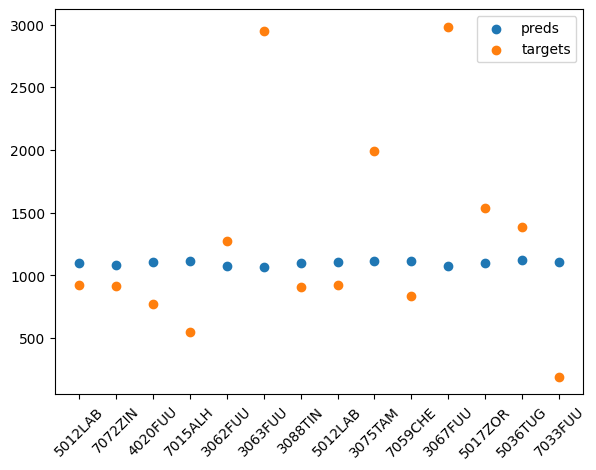

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics, preds_original_units, targets_original_units = evaluate_finetuned_model(finetuned_model, test_ds, num_workers=0, batch_size=32)
print(metrics)

finetuned_model = load_finetuned_model(
    model_path = model_output_dir / experiment_name,
    task_type=task_type,
)

metrics, preds_original_units, targets_original_units = evaluate_finetuned_model(finetuned_model, test_ds, num_workers=0, batch_size=32)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.scatter(x=np.arange(len(preds_original_units)), y=preds_original_units, label='preds')
plt.scatter(x=np.arange(len(targets_original_units)), y=targets_original_units, label='targets')
plt.xticks(ticks=np.arange(len(test_df)), labels=test_df.sample_id.to_list(), rotation=45)
plt.legend()

### 4) Inference using Fine-Tuned end-to-end Presto

In this section, we apply the fine tuned model to generate a yield map on an unseen area. 
We need to indicate the spatial and temporal extent. The 2 cells below, offer a simple way for the user to provide these information and perform once again the extraction from CDSE of the EO time-series required by Presto. 
We also need to indicate the `output_dir` of where to save the datacube of the extraction, its `output_filename` and the `composite_window` which will be the same as used for finetuning the model.

In [10]:
map = ui_map(area_limit=7)

In [11]:
# select 1 year of data
slider = date_slider()

In [ ]:
output_dir = Path("/home/giorgia/Private/data/geomaize/regression")
output_filename = "inference_area"
inference_file = output_dir / f"{output_filename}.nc"

In [16]:
collect_inputs_for_inference(
    spatial_extent=map.get_extent(),
    temporal_extent=slider.get_processing_period(),
    output_path=output_dir,
    output_filename=f"{output_filename}.nc",
    composite_window=composite_window,
)

2025-08-11 16:57:41.651 | INFO     | scaleagdata_vito.utils.dateslider:get_processing_period:187 - Selected processing period: 2021-01-01 to 2021-12-31


Authenticated using refresh token.
0:00:00 Job 'j-2508111457434c6b92160d17c8064a2d': send 'start'
0:00:13 Job 'j-2508111457434c6b92160d17c8064a2d': created (progress 0%)
0:00:18 Job 'j-2508111457434c6b92160d17c8064a2d': created (progress 0%)
0:00:25 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:00:33 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:00:43 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:00:55 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:01:11 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:01:30 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:01:54 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:02:24 Job 'j-2508111457434c6b92160d17c8064a2d': queued (progress 0%)
0:03:01 Job 'j-2508111457434c6b92160d17c8064a2d': running (progress N/A)
0:03:48 Job 'j-2508111457434c6b92160d17c8064a2d': running (progress N/A)
0:04:46 Job 'j-2508111457434c6b92160d17c8064

Once the datacube has been extracted, we can perform the inference task using the finetuned model and visualize the predicted map. 

In [24]:
inference_file = output_dir / "inference_area.nc"
mask_path = None

In [25]:
finetuned_model = load_finetuned_model(model_output_dir / experiment_name, task_type=task_type)
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    composite_window=composite_window,
)

predictions = presto_model.predict(inference_file, mask_path=mask_path)
predictions_map = reshape_result(predictions, path_to_input_file=inference_file)

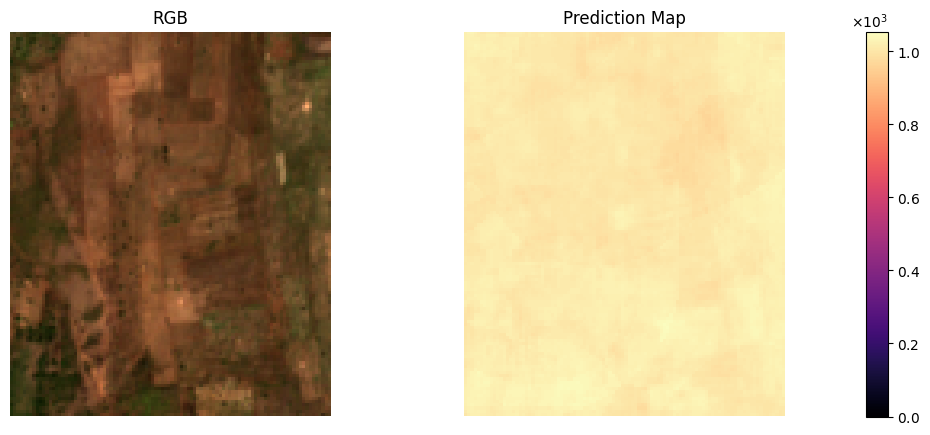

In [32]:
plot_results(prob_map=predictions_map, path_to_input_file=inference_file, task=task_type, ts_index=14)